In [1]:
import tqdm

def nop(it, *a, **k):
    return it

real_tqdm = tqdm.tqdm
tqdm.tqdm = nop

import cv2
import torch
import time
import os
import glob

import numpy as np
np.bool = np.bool_

from utils.inference.image_processing import crop_face, get_final_image, show_images
from utils.inference.video_processing import read_video, get_target, get_final_video, add_audio_from_another_video, face_enhancement
from utils.inference.core import model_inference

from network.AEI_Net import AEI_Net
from coordinate_reg.image_infer import Handler
from insightface_func.face_detect_crop_multi import Face_detect_crop
from arcface_model.iresnet import iresnet100
from models.pix2pix_model import Pix2PixModel
from models.config_sr import TestOptions

#os.environ["CUDA_VISIBLE_DEVICES"] = "2"


/compuworks/anaconda3/envs/xaiseung_ghost_cuda114/lib/python3.9/site-packages/kornia/augmentation/augmentation.py:1830: DeprecationWarning: GaussianBlur is no longer maintained and will be removed from the future versions. Please use RandomGaussianBlur instead.
  warnings.warn(
/compuworks/anaconda3/envs/xaiseung_ghost_cuda114/lib/python3.9/site-packages/mxnet/numpy/fallback.py:143: DeprecationWarning: In accordance with NEP 32, the function mirr was removed from NumPy version 1.20.  A replacement for this function is available in the numpy_financial library: https://pypi.org/project/numpy-financial
  mirr = onp.mirr
/compuworks/anaconda3/envs/xaiseung_ghost_cuda114/lib/python3.9/site-packages/mxnet/numpy/fallback.py:160: DeprecationWarning: In accordance with NEP 32, the function npv was removed from NumPy version 1.20.  A replacement for this function is available in the numpy_financial library: https://pypi.org/project/numpy-financial
  npv = onp.npv
/compuworks/anaconda3/envs/xaise

### Load Models

In [2]:
app = Face_detect_crop(name='antelope', root='./insightface_func/models')
app.prepare(ctx_id= 0, det_thresh=0.6, det_size=(640,640))

# main model for generation
G = AEI_Net(backbone='unet', num_blocks=2, c_id=512)
G.eval()
G.load_state_dict(torch.load('weights/G_unet_2blocks.pth', map_location=torch.device('cpu')))
G = G.cuda()
G = G.half()

# arcface model to get face embedding
netArc = iresnet100(fp16=False)
netArc.load_state_dict(torch.load('arcface_model/backbone.pth'))
netArc=netArc.cuda()
netArc.eval()

# model to get face landmarks
handler = Handler('./coordinate_reg/model/2d106det', 0, ctx_id=0, det_size=640)

# model to make superres of face, set use_sr=True if you want to use super resolution or use_sr=False if you don't
use_sr = True
if use_sr:
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'
    torch.backends.cudnn.benchmark = True
    opt = TestOptions()
    #opt.which_epoch ='10_7'
    model = Pix2PixModel(opt)
    model.netG.train()

input mean and std: 127.5 127.5
find model: ./insightface_func/models/antelope/glintr100.onnx recognition
find model: ./insightface_func/models/antelope/scrfd_10g_bnkps.onnx detection
set det-size: (640, 640)
loading ./coordinate_reg/model/2d106det 0
input mean and std: 127.5 127.5
find model: ./insightface_func/models/antelope/glintr100.onnx recognition
find model: ./insightface_func/models/antelope/scrfd_10g_bnkps.onnx detection
set det-size: (640, 640)


[01:04:40] ../src/nnvm/legacy_json_util.cc:208: Loading symbol saved by previous version v1.5.0. Attempting to upgrade...
[01:04:40] ../src/nnvm/legacy_json_util.cc:216: Symbol successfully upgraded!
[01:04:40] ../src/base.cc:79: cuDNN lib mismatch: linked-against version 8204 != compiled-against version 8101.  Set MXNET_CUDNN_LIB_CHECKING=0 to quiet this warning.


Network [LIPSPADEGenerator] was created. Total number of parameters: 72.2 million. To see the architecture, do print(network).
Load checkpoint from path:  weights/10_net_G.pth


### Set here path to source image and video for faceswap

In [3]:
image_to_image = False

In [4]:
"""
choose not really long videos, coz it can take a lot of time othervise 
choose source image as a photo -- preferable a selfie of a person
"""
if image_to_image:
    path_to_target = 'examples/images/beckham.jpg'
else:
    #path_to_video = 'examples/videos/random_gif.gif'
    path_to_video = "examples/videos/01__hugging_happy.mp4"
#source_full = cv2.imread('examples/images/elon_musk.jpg')
source_full = cv2.imread('examples/images/Bob-Ross.webp')
OUT_VIDEO_NAME = "examples/results/result_tmp.mp4"
crop_size = 224 # don't change this
BS = 60

[[391.75534 277.68085]
 [457.6292  245.26158]
 [468.77563 315.08746]
 [399.4389  374.28146]
 [458.98822 351.14127]]
[array([[391.75534, 277.68085],
       [457.6292 , 245.26158],
       [468.77563, 315.08746],
       [399.4389 , 374.28146],
       [458.98822, 351.14127]], dtype=float32)]


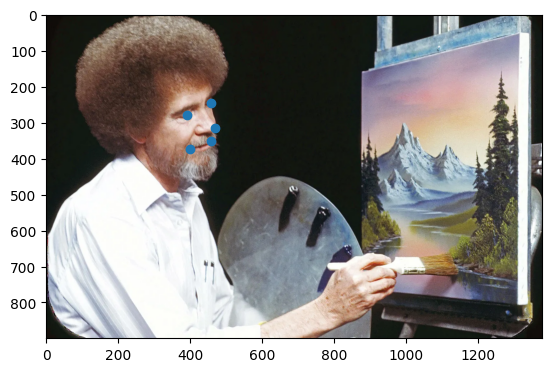

[[ 6.60493824e-01 -6.89332283e-02 -1.45022936e+02]
 [ 6.89332283e-02  6.60493824e-01 -9.97183862e+01]]
[[ 94.58760977 110.69305859]
 [140.33165926  93.82123237]
 [142.88047957 140.70915508]
 [ 93.00356349 175.02682194]
 [133.93064771 163.84779087]]


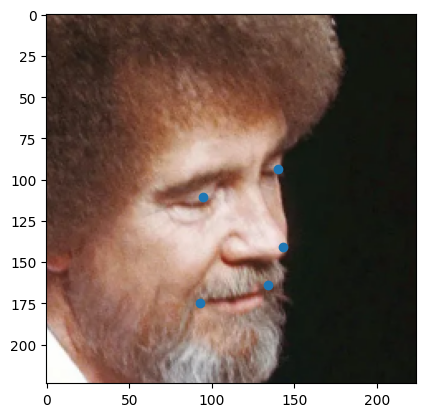

'\ntry:    \n    source = crop_face(source_full, app, crop_size)[0]\n    print(source.shape)\n    source = [source[:, :, ::-1]]\n    print("Everything is ok!")\nexcept TypeError:\n    print("Bad source images")\n'

In [5]:
# check, if we can detect face on the source image
from utils.inference.video_processing import smooth_landmarks

kps = app.get(source_full, crop_size)
print(kps[0])
smooth_kps = smooth_landmarks([kps], n=2)
print(smooth_kps[0])
import matplotlib.pyplot as plt


plt.imshow(source_full[:,:,::-1])
plt.scatter(kps[0][:, 0], kps[0][:, 1])
plt.show()
from insightface.utils import face_align
M, _ = face_align.estimate_norm(kps[0], crop_size, mode ='None') 
print(M)

kps_3 = np.ones([kps[0].shape[0], 3])

kps_3[:, :2] = kps[0]


M_kps = kps_3.dot(M.T)
print(M_kps)

# M = (2x3) Affine matrix
align_img = cv2.warpAffine(source_full, M, (crop_size,crop_size), borderValue=0.0)

plt.imshow(align_img[:,:,::-1])
plt.scatter(M_kps[:, 0], M_kps[:, 1])
plt.show()
source = [align_img]
"""
try:    
    source = crop_face(source_full, app, crop_size)[0]
    print(source.shape)
    source = [source[:, :, ::-1]]
    print("Everything is ok!")
except TypeError:
    print("Bad source images")
"""

[[107.34583  132.78123 ]
 [168.65572  129.4011  ]
 [155.65323  172.92947 ]
 [112.754486 203.13289 ]
 [162.01718  200.46866 ]]
[array([[107.34583 , 132.78123 ],
       [168.65572 , 129.4011  ],
       [155.65323 , 172.92947 ],
       [112.754486, 203.13289 ],
       [162.01718 , 200.46866 ]], dtype=float32)]


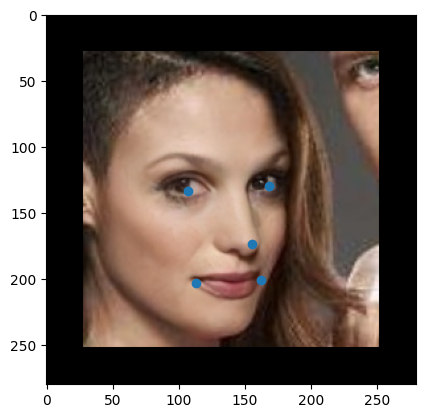

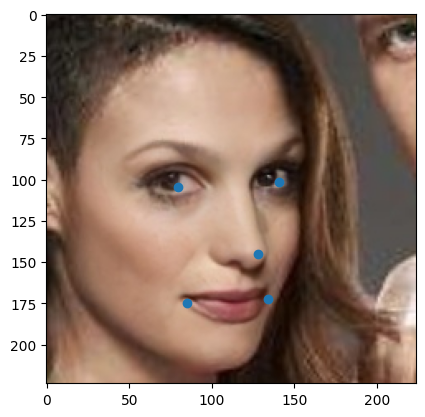

'\nfrom insightface.utils import face_align\nM, _ = face_align.estimate_norm(kps[0], crop_size, mode =\'None\') \nprint(M)\n\nkps_3 = np.ones([kps[0].shape[0], 3])\n\nkps_3[:, :2] = kps[0]\n\n\nM_kps = kps_3.dot(M.T)\nprint(M_kps)\n\n# M = (2x3) Affine matrix\nalign_img = cv2.warpAffine(source_full, M, (crop_size,crop_size), borderValue=0.0)\n\nplt.imshow(align_img[:,:,::-1])\nplt.scatter(M_kps[:, 0], M_kps[:, 1])\nplt.show()\nsource = [align_img]\n"""\ntry:    \n    source = crop_face(source_full, app, crop_size)[0]\n    print(source.shape)\n    source = [source[:, :, ::-1]]\n    print("Everything is ok!")\nexcept TypeError:\n    print("Bad source images")\n"""\n'

In [7]:
# check, if we can detect face on the source image
from utils.inference.video_processing import smooth_landmarks

"""
choose not really long videos, coz it can take a lot of time othervise 
choose source image as a photo -- preferable a selfie of a person
"""
if image_to_image:
    path_to_target = 'examples/images/beckham.jpg'
else:
    #path_to_video = 'examples/videos/random_gif.gif'
    path_to_video = "examples/videos/01__hugging_happy.mp4"
#source_full = cv2.imread('examples/images/elon_musk.jpg')
source_full = cv2.imread('examples/results/VggFace2-crop/src000002_0002_01_tgt000403_0159_01.jpg')
crop_size = 224 # don't change this
pad_size = crop_size//8

source_full = cv2.copyMakeBorder(source_full, pad_size,pad_size,pad_size,pad_size, cv2.BORDER_CONSTANT, value=(0, 0, 0))
OUT_VIDEO_NAME = "examples/results/result_tmp.mp4"

BS = 60

kps = app.get(source_full, crop_size)
print(kps[0])
smooth_kps = smooth_landmarks([kps], n=2)
print(smooth_kps[0])
import matplotlib.pyplot as plt


plt.imshow(source_full[:,:,::-1])
plt.scatter(kps[0][:, 0], kps[0][:, 1])
plt.show()

kps[0] -= pad_size
plt.imshow(source_full[pad_size:-pad_size,
                       pad_size:-pad_size,::-1])
plt.scatter(kps[0][:, 0], kps[0][:, 1])
plt.show()
'''
from insightface.utils import face_align
M, _ = face_align.estimate_norm(kps[0], crop_size, mode ='None') 
print(M)

kps_3 = np.ones([kps[0].shape[0], 3])

kps_3[:, :2] = kps[0]


M_kps = kps_3.dot(M.T)
print(M_kps)

# M = (2x3) Affine matrix
align_img = cv2.warpAffine(source_full, M, (crop_size,crop_size), borderValue=0.0)

plt.imshow(align_img[:,:,::-1])
plt.scatter(M_kps[:, 0], M_kps[:, 1])
plt.show()
source = [align_img]
"""
try:    
    source = crop_face(source_full, app, crop_size)[0]
    print(source.shape)
    source = [source[:, :, ::-1]]
    print("Everything is ok!")
except TypeError:
    print("Bad source images")
"""
'''

In [8]:
image_dir = "examples/results/VggFace2-crop"
detect_dir = f"{image_dir}/detections"
os.makedirs(detect_dir, exist_ok=True)

image_paths = glob.glob(f"{image_dir}/*.jpg")
for image_path in real_tqdm(image_paths):
    image_file_name = os.path.basename(image_path)
    source_full = cv2.imread(image_path)
    crop_size = 224 # don't change this
    pad_size = crop_size//3
    source_full = cv2.copyMakeBorder(source_full, pad_size,pad_size,pad_size,pad_size, cv2.BORDER_CONSTANT, value=(0, 0, 0))
    kps = app.get(source_full, crop_size)
    kps[0] -= pad_size
    with open(os.path.join(detect_dir, os.path.splitext(image_file_name)[0]+".txt"), "w") as file:
        for i in range(len(kps[0])):
            file.write(f"{kps[0][i, 0]:.2f} {kps[0][i, 1]:.2f}\n")


100%|██████████| 86310/86310 [12:07<00:00, 118.64it/s]


In [14]:
os.path.basename("qwer/asdf.txt")

'asdf.txt'